In [1]:
import nexradaws
import tempfile
import os
import shutil
import pyart
from matplotlib import pyplot as plt
from netCDF4 import num2date
import numpy as np

from dask_kubernetes import KubeCluster
from dask.distributed import Client
from dask.distributed import wait, progress
#import six


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/srv/conda/envs/notebook/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/srv/conda/envs/notebook/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
templocation = tempfile.mkdtemp()
conn = nexradaws.NexradAwsInterface()
scans = conn.get_avail_scans('2011', '05', '20','KVNX')


In [3]:
scans[10:20]

[<AwsNexradFile object - 2011/05/20/KVNX/KVNX20110520_004338_V06.gz>,
 <AwsNexradFile object - 2011/05/20/KVNX/KVNX20110520_004758_V06.gz>,
 <AwsNexradFile object - 2011/05/20/KVNX/KVNX20110520_005219_V06.gz>,
 <AwsNexradFile object - 2011/05/20/KVNX/KVNX20110520_005639_V06.gz>,
 <AwsNexradFile object - 2011/05/20/KVNX/KVNX20110520_010100_V06.gz>,
 <AwsNexradFile object - 2011/05/20/KVNX/KVNX20110520_010520_V06.gz>,
 <AwsNexradFile object - 2011/05/20/KVNX/KVNX20110520_010939_V06.gz>,
 <AwsNexradFile object - 2011/05/20/KVNX/KVNX20110520_011358_V06.gz>,
 <AwsNexradFile object - 2011/05/20/KVNX/KVNX20110520_011818_V06.gz>,
 <AwsNexradFile object - 2011/05/20/KVNX/KVNX20110520_012438_V06.gz>]

In [4]:
tscan = scans[10]

In [5]:
lcn = templocation
localfiles = conn.download(tscan,lcn)

Downloaded KVNX20110520_004338_V06.gz
1 out of 1 files downloaded...0 errors


In [6]:
radar = pyart.io.read(localfiles.success[0].filepath)

/srv/conda/envs/notebook/lib/python3.6/site-packages/pyart/graph/radarmapdisplay.py:268: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes.
  UserWarning)
/srv/conda/envs/notebook/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/srv/conda/envs/notebook/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


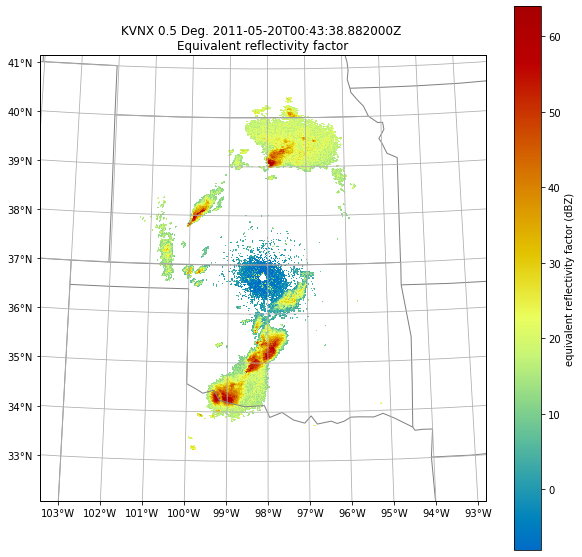

In [7]:
myf = plt.figure(figsize=[10,10])
myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64)

In [8]:

# Select 10 'workers' under 'manual scaling' menu below and click 'Scale'
# Click on the 'Dashboard link' to monitor calculation progress
cluster = KubeCluster(n_workers=10)


In [29]:
cluster

In [30]:

# Attach Dask to the cluster
client = Client(cluster)

In [31]:
def simple_sum(scan_number):
    templocation = tempfile.mkdtemp()
    conn = nexradaws.NexradAwsInterface()
    scans = conn.get_avail_scans('2011', '05', '20','KVNX')
    tscan = scans[scan_number]
    localfiles = conn.download(tscan,templocation)
    try:
        this_dataset = pyart.io.read(localfiles.success[0].filepath)
        fp = 1
        time_start = num2date(this_dataset.time['data'][0], this_dataset.time['units'])
        tgates = float(this_dataset.ngates*this_dataset.nrays)
        zdat = this_dataset.fields['reflectivity']['data']
        fp = 2
        z0 = float(len(np.where(zdat > 0.)[0]))/tgates
        z10 = float(len(np.where(zdat > 10.)[0]))/tgates
        z40 = float(len(np.where(zdat > 40.)[0]))/tgates
        del this_dataset
        rv = (time_start, z0, z10, z40)
    except (TypeError, KeyError) as e:
        rv = 'error'
    return rv



In [32]:
simple_sum(1)

Downloaded KVNX20110520_000442_V06.gz
1 out of 1 files downloaded...0 errors


(datetime.datetime(2011, 5, 20, 0, 4, 42, 363000),
 0.06534495443326371,
 0.05331288367824821,
 0.002842844862139527)

In [33]:
client

Client Scheduler: tcp://10.51.15.7:37243 Dashboard: /user/anl-digr-saws-demo-vzjk3dwz/proxy/8787/status,Cluster Workers: 7 Cores: 14 Memory: 49.00 GB


In [34]:
future = client.map(simple_sum, range(len(scans)))


In [35]:
progress(future)

VBox()

In [28]:
my_data = client.gather(future)

KeyError: 'credential_provider'

In [79]:
#filtered_data = filter(lambda i:not(type(i) is str), my_data)
filtered_data = [value for value in my_data if type(value) != str]

In [80]:
len(filtered_data)

320

In [81]:
times = np.array([tpl[0] for tpl in filtered_data])
z0 = np.array([tpl[1] for tpl in filtered_data])
z10 = np.array([tpl[2] for tpl in filtered_data])
z40 = np.array([tpl[3] for tpl in filtered_data])


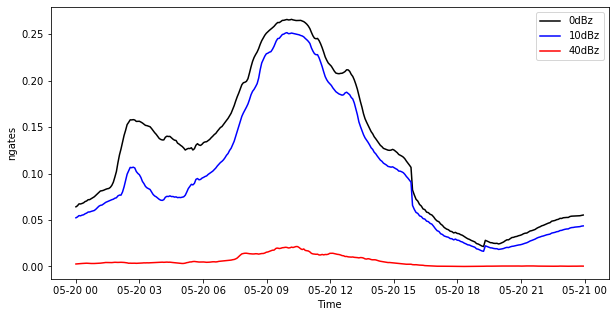

In [82]:
my_fig = plt.figure(figsize=[10,5])
plt.plot(times, z0, '-k', label='0dBz')
plt.plot(times, z10, '-b', label='10dBz')
plt.plot(times, z40, '-r', label='40dBz')
plt.ylabel('ngates')
plt.xlabel('Time')
plt.legend()